# Lognormal test

This is a comparison of the direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will use a set of points drawn from a "lognormal catalog" and impose a "survey footprint" covering a fraction of the sky defined by intervals in $\cos\theta$ and $\phi$ with small "veto" regions.

See the [lognormal catalog notebook](lognormal_catalog.ipynb) for more details of the mock catalog and the cells below for the mask.

In [1]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../sht')
#
from sht                import DirectSHT
from mocks              import LogNormalMocks
from mask_deconvolution import MaskDeconvolution
from window_function    import make_cl

In [3]:
# Get a random number generator.
seed = None
rng  = np.random.default_rng(seed)

## Generate a mock catalog and randoms

We start by generating two points sets: the data catalog (from a lognormal model) and the random catalog that implicitly defines the mask, the window function, etc.

In [4]:
# Define our footprint by intervals in cos(theta) and phi.
cthta_min = -0.4
cthta_max =  0.5
theta_min =  np.arccos(cthta_max)
theta_max =  np.arccos(cthta_min)
phi_min   =  0.2
phi_max   =  5.0
#
print("Sky fraction {:f}".format( (phi_max-phi_min)*(cthta_max-cthta_min)/(4*np.pi) ))

Sky fraction 0.343775


In [5]:
# To put more structure in the mask, let's "cut out" various pieces of the
# sky, vetoing both data and random points.
# Generate a random catalog of "veto centers" and "radii".
nveto = 10
tveto = np.arccos( rng.uniform(low=cthta_min,high=cthta_max,size=nveto) )
pveto = rng.uniform(low=phi_min,high=phi_max,size=nveto)
rveto = np.ones_like(tveto) * 0.999
# and convert these into 3D unit vectors
nveto = np.zeros( (nveto,3) )
nveto[:,0] = np.sin(tveto)*np.cos(pveto)
nveto[:,1] = np.sin(tveto)*np.sin(pveto)
nveto[:,2] = np.cos(tveto)

In [6]:
def veto_points(tt,pp,wt,nveto,rveto):
    """Returns 'trimmed' tt, pp, wt arrays vetoed by a set of 'veto' points."""
    nh      = np.zeros( (tt.size,3) )
    nh[:,0] = np.sin(tt)*np.cos(pp)
    nh[:,1] = np.sin(tt)*np.sin(pp)
    nh[:,2] = np.cos(tt)
    ww      = np.ones(tt.size,dtype='bool')
    for i in range(nveto.shape[0]):
        ww &= np.dot(nh,nveto[i,:])<rveto[i]
    return( (tt[ww],pp[ww],wt[ww]) )

In [7]:
# Generate a lognormal mock
npnt_fullsky = 3 * 250000
#
# Initialize a helper object from which to draw realizations
nside_mockmaking = 2048
nside_mockmaking = 8192
Mocks_obj = LogNormalMocks(npnt_fullsky,nside=nside_mockmaking, 
                           theta_range=[theta_min,theta_max],
                           phi_range=[phi_min,phi_max])
#
print('Npnt/Npix=', npnt_fullsky/hp.nside2npix(nside_mockmaking))
cl_theory = Mocks_obj.get_theory_Cl(lmax_out=1000,gauss_order=3000)
# Draw a realization, specifying the random seed if you want
tdata,pdata,wdata = Mocks_obj(seed=0)
#
ndata = len(tdata)
print("Kept {:d} objects in cut.".format(ndata))

Npnt/Npix= 0.0009313225746154785
gmap in range (-3.979337e+00,3.798165e+00)
emap in range (1.236340e-05,2.950284e-02)
Kept 262851 objects in cut.


In [8]:
# Code to generate a random catalog.
def generate_randoms(nrand):
    """Generate nrand randoms in our footprint."""
    trand = np.arccos( rng.uniform(low=cthta_min,high=cthta_max,size=nrand) )
    prand = rng.uniform(low=phi_min,high=phi_max,size=nrand)
    wrand = np.ones_like(trand) * float(ndata)/float(nrand)
    return( (trand,prand,wrand) )

In [9]:
# Generate the randoms.
nrand = 30*ndata
trand,prand,wrand = generate_randoms(nrand)

In [10]:
# Run the data and randoms through the "veto mask".
tdata,pdata,wdata = veto_points(tdata,pdata,wdata,nveto,rveto)
trand,prand,wrand = veto_points(trand,prand,wrand,nveto,rveto)
# Correct for the veto'd points.
ndata  = len(tdata)
nrand  = len(trand)
wrand *= np.sum(wdata)/np.sum(wrand)

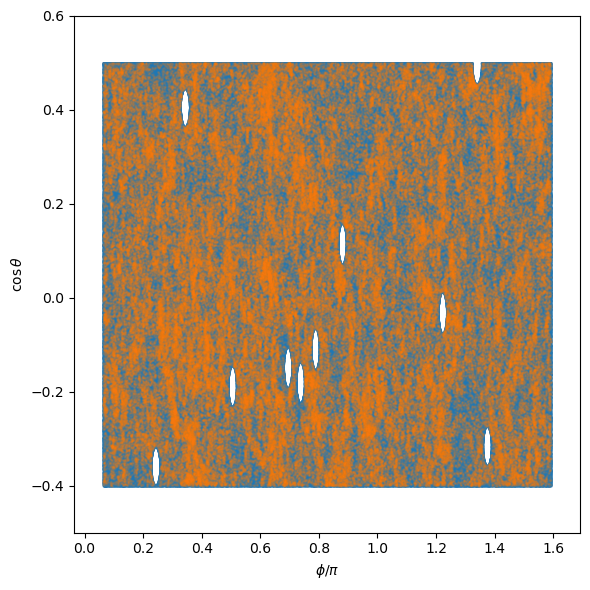

In [11]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
#
ax.scatter(prand/np.pi,np.cos(trand),s=1,c='C0',alpha=0.1,label='Rand',rasterized=True)
ax.scatter(pdata/np.pi,np.cos(tdata),s=1,c='C1',alpha=0.1,label='Data',rasterized=True)
#
ax.set_xlim(phi_min/np.pi-0.1,phi_max/np.pi+0.1)
ax.set_ylim(cthta_min-0.1,cthta_max+0.1)
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$\cos\theta$')
plt.tight_layout()

## Harmonic analysis

First do a "direct harmonic analysis" of the data and random points by applying the SHT, differencing, and then computing the psuedo-spectrum.  We will start by finding the window function from the randoms ...

In [12]:
# Set up an sht instance.  We will set Nx to be quite large, so that we are
# confident in our interpolation.
Nl   = 350
Nx   = 4*Nl+1
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 350 , Nx= 1401  and xmax= 0.625
For randoms, Direct SHT has Nl= 414 , Nx= 1401  and xmax= 0.625


In [13]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl) - sn

Sorting took  1.1858606338500977  seconds.
Digitizing & reshaping took  5.89513635635376  seconds.
Precomputing vs took  10.942520380020142  seconds.
Computing alm's took  0.5562667846679688  seconds.
Sorting took  0.9606153964996338  seconds.
Digitizing & reshaping took  4.699620962142944  seconds.
Precomputing vs took  7.169264793395996  seconds.
Computing alm's took  0.1948709487915039  seconds.


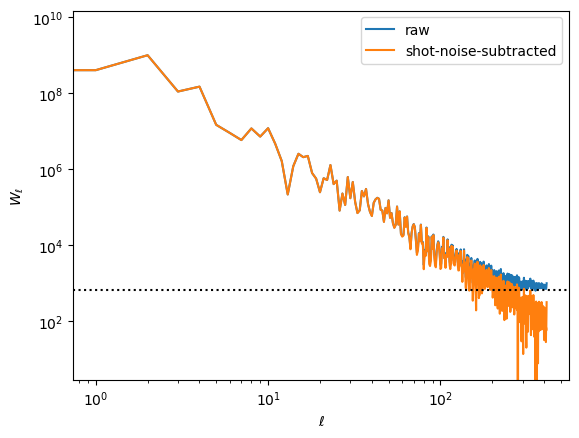

In [14]:
plt.loglog(wl+sn,label='raw')
plt.loglog(wl   ,label='shot-noise-subtracted')
plt.axhline(sn,ls=':',color='k')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 1min 4s, sys: 436 ms, total: 1min 4s
Wall time: 1min 4s

Row sums of Mbl:
[1.00006795 1.00004914 1.00004476 1.00004314 1.00005519 1.00005998
 1.00005891 1.00006245 1.00007435 1.00008745 1.00009154 1.00010059
 1.00011458 1.00014225 1.00016718 1.00017859 1.00021202 1.00029042
 1.00038891 1.00047693 1.00061291 1.00100121 1.00224576 1.00233853
 1.06127437]


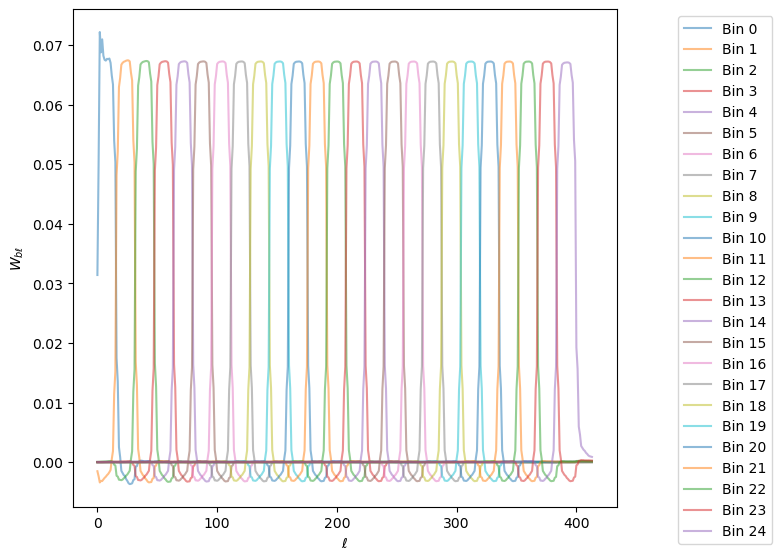

In [15]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**4
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))
# and plot the matrix:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
ax.legend(bbox_to_anchor=(1.1,1.0))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()

Sorting took  0.01896357536315918  seconds.
Digitizing & reshaping took  3.6770544052124023  seconds.
Precomputing vs took  5.574928522109985  seconds.
Computing alm's took  0.3530862331390381  seconds.
Sorting took  0.015503883361816406  seconds.
Digitizing & reshaping took  2.950935125350952  seconds.
Precomputing vs took  4.912408351898193  seconds.
Computing alm's took  0.14438962936401367  seconds.
Sorting took  1.2350826263427734  seconds.
Digitizing & reshaping took  4.361347675323486  seconds.
Precomputing vs took  6.1379570960998535  seconds.
Computing alm's took  0.01787877082824707  seconds.
Sorting took  0.8811721801757812  seconds.
Digitizing & reshaping took  3.311995506286621  seconds.
Precomputing vs took  4.988237619400024  seconds.
Computing alm's took  0.017138957977294922  seconds.
hatC in range [3.385224e+04,8.913691e+06]


Text(0, 0.5, '$\\hat{C}_\\ell$')

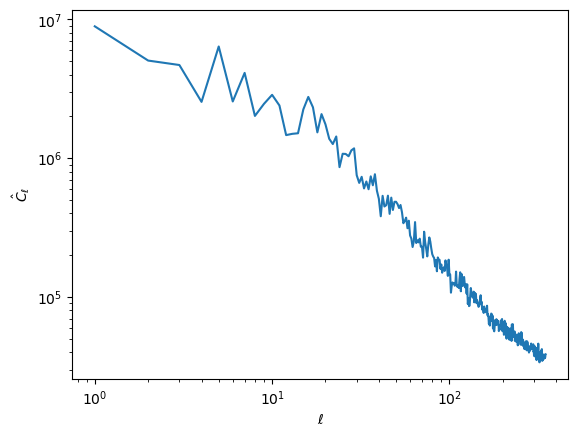

In [16]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata)
hdcl = hp.alm2cl(hdat)
#
# Do the same for the randoms.
hran = sht(trand,prand,wrand)
hrcl = hp.alm2cl(hran)
#
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')

In [17]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [18]:
print(binned_ells)
print(hdif_decoupled)

[ 39.5  55.5  71.5  87.5 103.5 119.5 135.5 151.5 167.5 183.5 199.5 215.5
 231.5 247.5 263.5 279.5 295.5 311.5 327.5 343.5 359.5]
[ 4.31021596e-04  2.92591046e-04  1.94240838e-04  1.37396704e-04
  1.07292158e-04  9.97225639e-05  7.88467535e-05  6.93392133e-05
  5.80537426e-05  4.97386413e-05  4.93027831e-05  4.47081382e-05
  4.25558038e-05  4.07358400e-05  3.66820316e-05  3.43629905e-05
  3.43810008e-05  3.21292527e-05  2.99424890e-05  2.76912579e-05
 -2.17965783e-06]


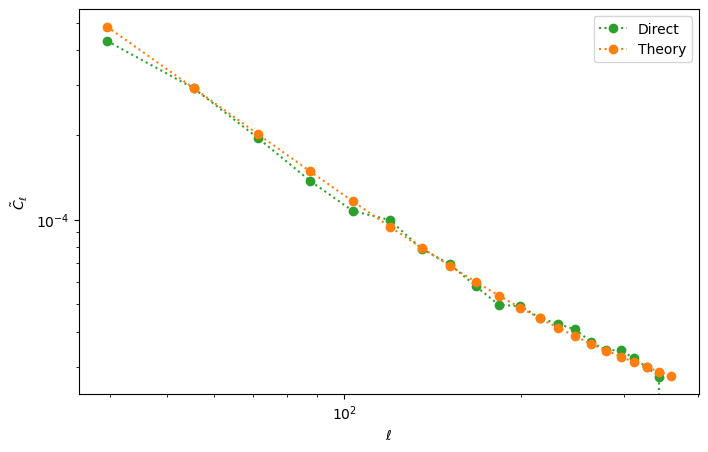

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()

## Pixel-based analysis

Now let's look at the same point set by first binning them on a map and then analyzing them using the "standard" healpy routines.

In [20]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = hp.nside2npix(nside)
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

dmap.sum= 16213939702.779518
rmap.sum= 16213939702.775675
fsky= 0.3382301330566406


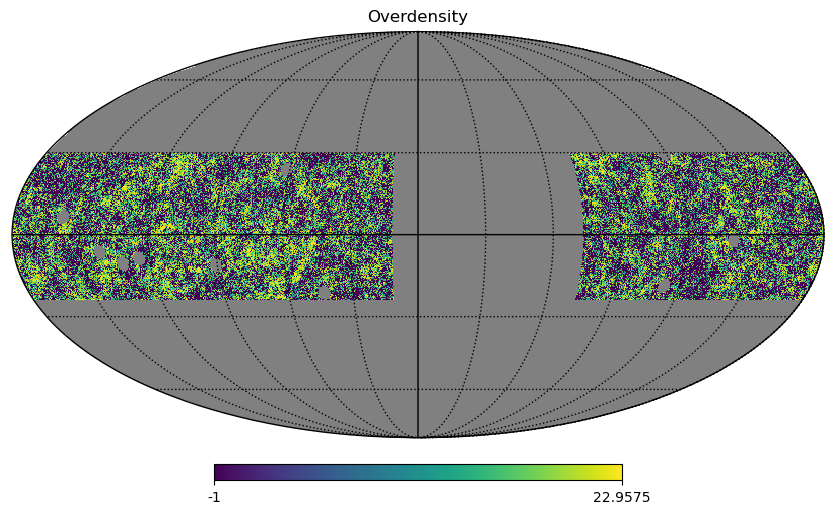

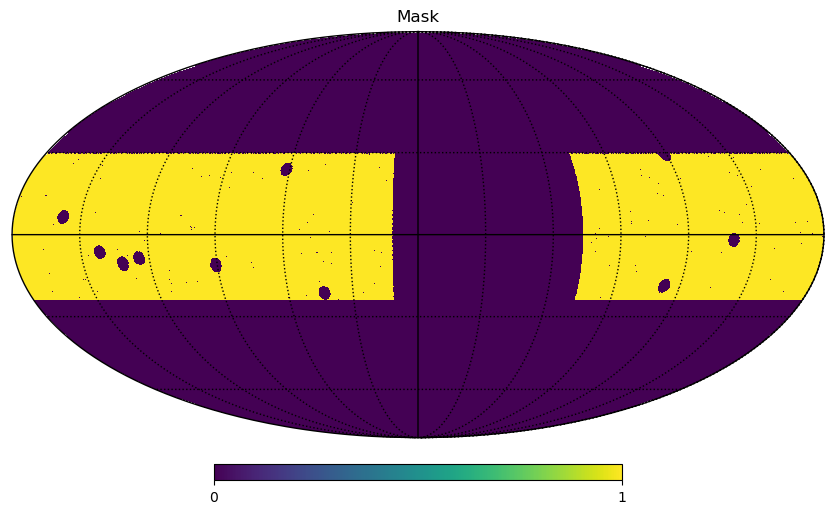

In [21]:
# Show an example at some nside.
nside= 256
npix = hp.nside2npix(nside)
dmap = make_map(tdata,pdata,wdata,nside)
rmap = make_map(trand,prand,wrand,nside)
#
print("dmap.sum=",np.sum(dmap))
print("rmap.sum=",np.sum(rmap))
#
# Remove pixels where we have data but no randoms,
# then generate the 1+delta field.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
msk = np.nonzero(rmap>0.5*avg)[0]
#
omap      = np.zeros(npix,dtype='f8')
omap[msk] = dmap[msk]/rmap[msk]
omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
mask      = np.zeros(npix)
mask[msk] = 1.0
#
fsky = len(msk)/float(len(mask))
print("fsky=",fsky)
#
ma = hp.ma(omap)
ma.mask = (mask<0.5)
hp.mollview(ma,norm='hist',title='Overdensity')
hp.graticule()
#
hp.mollview(mask,title='Mask')
hp.graticule()

Text(0, 0.5, '$\\hat{C}_\\ell$')

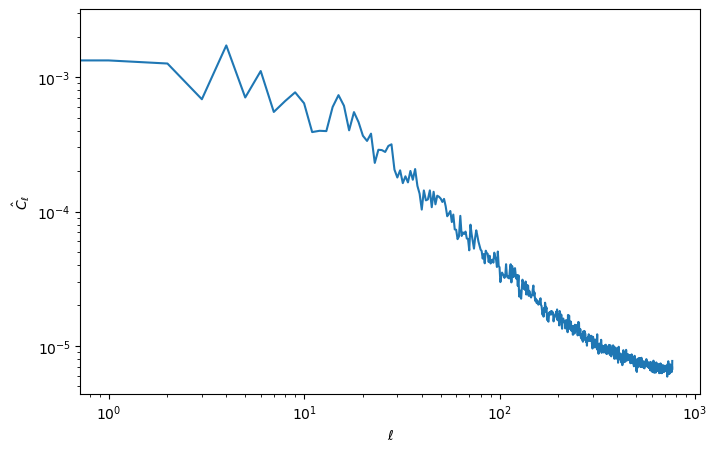

In [22]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
#
cl_via_map = hp.anafast(omap)
ax.loglog(cl_via_map[1:-1])
#
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')

In [23]:
# Measure the W_l
wl_maplevel = hp.anafast(mask)

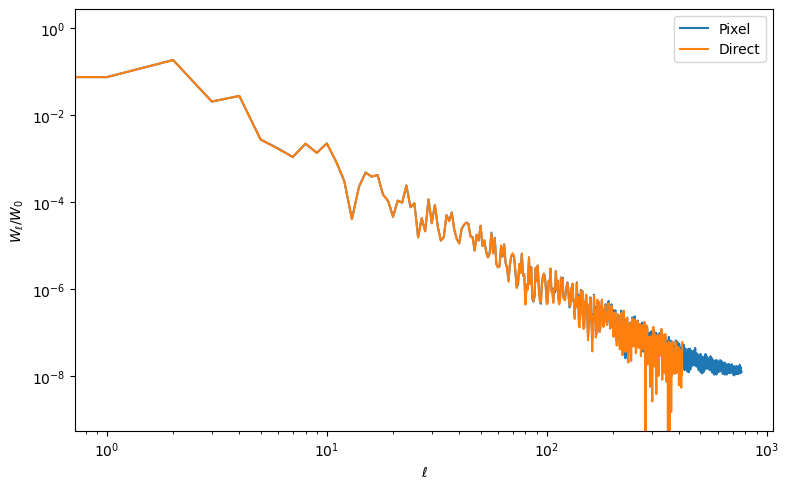

In [24]:
# Plot the window function and compare it to the "direct" method.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.loglog(wl_maplevel/wl_maplevel[0],label='Pixel')
ax.loglog(wl/wl[0],label='Direct')
#
ax.legend()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_\ell/W_0$')
#
plt.tight_layout()

In [25]:
# We need to initialize a different mode-decoupling object
# because our map-level mask has a different normalization
MD2 = MaskDeconvolution(Nl+buffer_ells,wl_maplevel)
#
# Deconvolve the mask to produce a "map delta" estimate of tilde{C}_ell.
binned_ells,mdel_decoupled = MD2(cl_via_map,bins)
binned_ells,mdel_decoupled = binned_ells[Ndiscard:-Ndiscard], mdel_decoupled[Ndiscard:-Ndiscard]

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


(1e-05, 0.001)

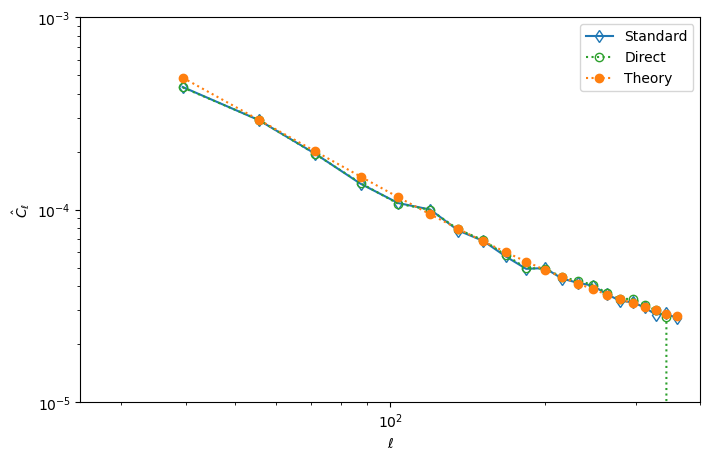

In [26]:
# Let's just plot the angular power spectrum so we know what we've got.
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,mdel_decoupled,'d-',color='C0',\
        mfc='None',label='Standard')
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',\
        mfc='None',label='Direct')
#
# Compare to the theory convolved with the bandpower window function.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells,clt_conv[Ndiscard:-Ndiscard],'o:',\
        color='C1',label='Theory')
#
ax.legend()
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\hat{C}_\ell$')
ax.set_xlim([25,400])
ax.set_ylim([1e-5,1e-3])

# Compare to standard analysis as a function of nside

Now we can compare the direct SHT approach to the standard one, with the latter using a number of randoms adapted to the pixelization 

In [27]:
factor = 25 # The ratio of randoms to pixels

In [28]:
# Let's save ourselves some time by using the same W_l irrespective of the number of randoms
# To give ourselves the best chance, compute this at high resolution.
nside = 512
npix  = hp.nside2npix(nside)
nrand = int(factor*npix*fsky)
trand,prand,wrand = generate_randoms(nrand)
trand,prand,wrand = veto_points(trand,prand,wrand,nveto,rveto)
rmap = make_map(trand,prand,wrand,nside)
nrand  = len(trand)
wrand *= np.sum(wdata)/np.sum(wrand)
#
# Make a binary mask.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
msk = np.nonzero(rmap>0.5*avg)[0]
#
mask      = np.zeros(npix)
mask[msk] = 1.0
# Measure the W_l and trim it to the same size as our direct W_l.
wl_maplevel = hp.anafast(mask)
wl_maplevel = wl_maplevel[:wl.size]

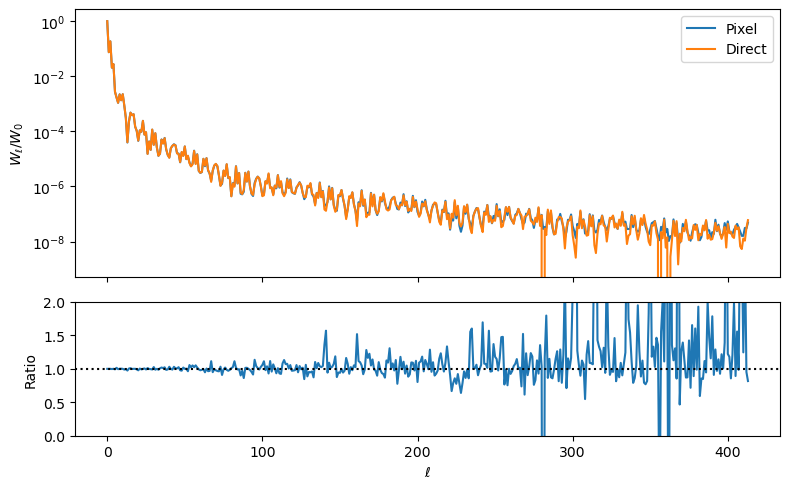

In [29]:
# Plot the window function and compare it to the "direct" method.
fig,ax = plt.subplots(2,1,sharex=True,figsize=(8,5),\
                      gridspec_kw={'height_ratios':[2,1]})
#
ells = np.arange(wl_maplevel.size)
ax[0].plot(ells,wl_maplevel/wl_maplevel[0],label='Pixel')
ax[0].plot(ells,wl/wl[0],label='Direct')
#
ax[1].plot(ells,(wl_maplevel/wl_maplevel[0])/(wl/wl[0]))
ax[1].axhline(1.0,ls=':',color='k')
#
ax[0].legend()
ax[0].set_yscale('log')
ax[1].set_ylim(0,2)
ax[1].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$W_\ell/W_0$')
ax[1].set_ylabel(r'Ratio')
#
plt.tight_layout()

In [30]:
# Make a mode-decoupling object to go with the mask.
MD2 = MaskDeconvolution(Nl+buffer_ells,wl_maplevel)

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...


For nside= 256, nrandoms=   6649875
For nside= 512, nrandoms=  26599500


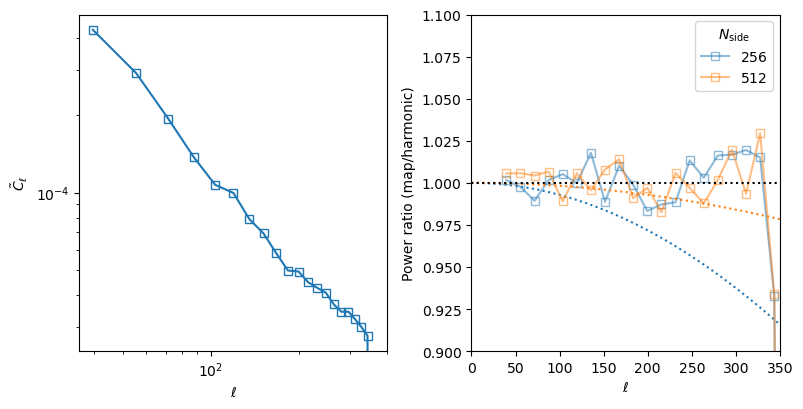

In [31]:
fig,ax = plt.subplots(1,2,sharey=False,figsize=(8,4.2))
#
ax[0].loglog(binned_ells,hdif_decoupled,'s-',mfc='None')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\tilde{C}_\ell$')
#
icol= 0
for nside in [256,512]:
    npix  = hp.nside2npix(nside)
    nrand = int(factor*npix*fsky)
    print('For nside={:4d}, nrandoms={:10d}'.format(nside,nrand))
    trand,prand,wrand = generate_randoms(nrand)
    trand,prand,wrand = veto_points(trand,prand,wrand,nveto,rveto)
    wrand *= np.sum(wdata)/np.sum(wrand)
    #
    dmap = make_map(tdata,pdata,wdata,nside)
    rmap = make_map(trand,prand,wrand,nside)
    #
    msk = np.nonzero(rmap>0)[0]
    avg = np.mean(rmap[msk])
    msk = np.nonzero(rmap>0.5*avg)[0]
    #
    omap      = np.zeros(npix,dtype='f8')
    omap[msk] = dmap[msk]/rmap[msk]
    omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
    mask      = np.zeros(npix)
    mask[msk] = 1.0
    #   
    cl_via_map= hp.anafast(omap)
    #
    # Deconvolve the mask
    binned_ells,mdel_decoupled = MD2(cl_via_map,bins)
    binned_ells,mdel_decoupled = binned_ells[Ndiscard:-Ndiscard],mdel_decoupled[Ndiscard:-Ndiscard]
    #
    ratio= hdif_decoupled/mdel_decoupled
    pixwn= hp.pixwin(nside)
    #
    ax[1].plot(binned_ells,ratio,'s-',color='C'+str(icol),alpha=0.5,\
               mfc='None',label='${:4d}$'.format(nside))
    ax[1].plot(np.arange(pixwn.size),pixwn,ls=':',color='C'+str(icol))
    icol = (icol+1)%10
ax[1].axhline(1.0,ls=':',color='k')
ax[1].set_ylabel(r'Power ratio (map/harmonic)')
ax[1].legend(title=r'$N_{\rm side}$')
ax[1].set_ylim(0.90,1.10)
ax[1].set_yscale('linear')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xlim([0,Nl+25])
#
plt.tight_layout()
plt.savefig('compare_pipelines.pdf')

# The End